In [90]:
%pylab inline
import sys
import pandas as pd
import numpy as np
import datetime
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from yahoo_finance import Share
import pandas.io.data as web
import seaborn

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [147]:
#trade logic: get positions
def get_positions(df): 
    diffdiff=df.resids
    max=0
    signal=0
    buysell= []
    #threshold=5
    for i in range(len(diffdiff)):
        if (abs(diffdiff[i])> max):
            max=abs(diffdiff[i])
            signal=0
        else:
            if (diffdiff[i]>0):
                signal = -1
            else:
                signal = 1
        if(diffdiff[i]*diffdiff[i-1]<= 0):
            signal=0
            max=abs(diffdiff[i])
        buysell.append(signal)
    return buysell

def get_positions2(df): 
    diffdiff=df.resids
    prices = df.prices
    max=0
    signal=0
    buysell= []
    #threshold=5
    for i in range(len(diffdiff)):
        if (abs(diffdiff[i])> max):
            max=abs(diffdiff[i])
            signal=0
        else:
            if (diffdiff[i]>prices[i]/12):
                signal = -1
            elif (diffdiff[i]<-prices[i]/12):
                signal = 1
            else:
                signal = 0
        if(diffdiff[i]*diffdiff[i-1]<= 0):
            signal=0
            max=abs(diffdiff[i])
        buysell.append(signal)
    return buysell

In [15]:
def entire_system(symbol, Q, R):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    #prices=np.asarray(list(prices))
    prices=prices.astype(float)

    kf=KalmanFilter(transition_matrices=[[1,1],[0,1]],observation_matrices=[[1,0]],
                    initial_state_mean=[prices[0],0],transition_covariance=[[Q,0],[0,Q]],
                    observation_covariance=R) #TC -> Q ;; OC -> R
    # kf=kf.em(prices,n_iter=5)
    (a,b)=kf.filter(prices)

    data = pd.DataFrame()
    data['prices']= prices
    data['kalman_price'] = a[:,0]
    data['kalman_vel'] = a[:,1]
    data['kalman_predict'] = a[:,0]+a[:,1]

    data['resids'] = data.prices - data.kalman_price

    bs = get_positions(data)
    data['position']= bs
    data['daily_rets'] = (data['prices'].shift(-1) - data['prices']) / data['prices']
    data['returns'] = data.position * data.daily_rets
    data['eq_curve'] = np.cumprod(data.returns+1)

    return data

In [117]:
def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    #prices=np.asarray(list(prices))
    prices=prices.astype(float)
    return prices

def get_results(prices, Q, R):
    kf=KalmanFilter(transition_matrices=[[1,1],[0,1]],observation_matrices=[[1,0]],
                    initial_state_mean=[prices[0],0],transition_covariance=[[Q,0],[0,Q]],
                    observation_covariance=R) #TC -> Q ;; OC -> R
    # kf=kf.em(prices,n_iter=5)
    (a,b)=kf.filter(prices)

    data = pd.DataFrame()
    data['prices']= prices
    data['kalman_price'] = a[:,0]
    data['kalman_vel'] = a[:,1]
    data['kalman_predict'] = a[:,0]+a[:,1]

    data['resids'] = data.prices - data.kalman_price

    bs = get_positions2(data)
    data['position']= bs
    data['daily_rets'] = (data['prices'].shift(-1) - data['prices']) / data['prices']
    data['returns'] = data.position * data.daily_rets
    data['eq_curve'] = np.cumprod(data.returns+1)

    return data

In [61]:
qr_test = pd.DataFrame()

In [66]:
qr_test.loc[5, 13] = 105

In [67]:
qr_test

,1,13
1,105,NaN
5,105,105


In [71]:
qr_test = pd.DataFrame()

In [100]:
for i in range(10):
    Q, R = 3.5, 10 + i
    data = get_results(prices, Q, R)
    years = (data.index[-1] - data.index[1]).days/365
    total_ret = data.eq_curve[-10]**(1/years) - 1
    var = np.std(data.returns)*np.sqrt(252)
    qr_test.loc[str(Q), R] = total_ret/var

/Users/liamconnell/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


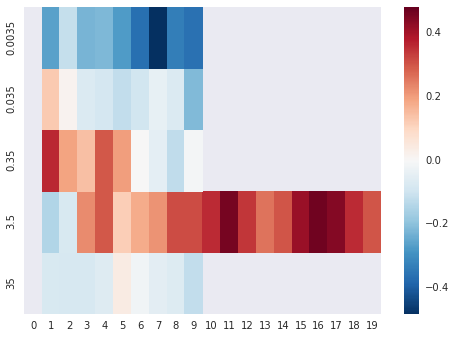

In [101]:
seaborn.heatmap(qr_test)

annual return: -0.0408240413442
variance: 0.212118661914
sharpe: -0.192458508723


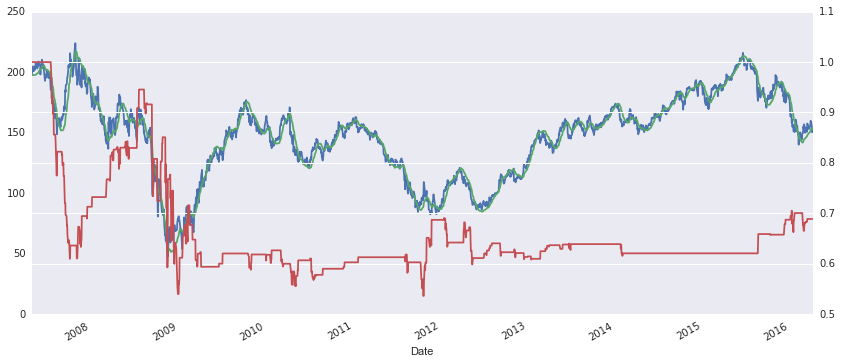

In [144]:
if True:
    prices = get_prices('GS')

Q, R = 3.5, 160000
data = get_results(prices, Q, R)

data.prices.plot(figsize=(14,6))
data.kalman_price.plot()
data.eq_curve.plot(secondary_y=True)

years = (data.index[-1] - data.index[1]).days/365
total_ret = data.eq_curve[-10]**(1/years) - 1
print('annual return: %s' %total_ret)
var = np.std(data.returns)*np.sqrt(252)
print('variance: %s' %var)
print('sharpe: %s' %(total_ret/var))

annual return: -0.0715771826898
variance: 0.283577327652
sharpe: -0.252407987911


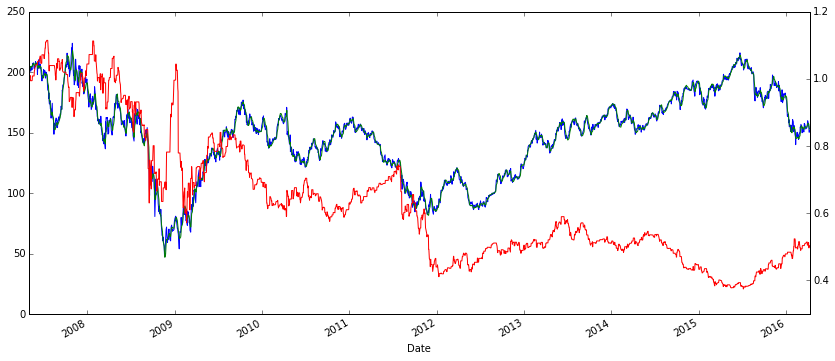

In [19]:
data = entire_system('GS', .035, 10)

data.prices.plot(figsize=(14,6))
data.kalman_price.plot()
data.eq_curve.plot(secondary_y=True)

years = (data.index[-1] - data.index[1]).days/365
total_ret = data.eq_curve[-10]**(1/years) - 1
print('annual return: %s' %total_ret)
var = np.std(data.returns)*np.sqrt(252)
print('variance: %s' %var)
print('sharpe: %s' %(total_ret/var))

annual return: -0.181759259849
variance: 0.362688601043
sharpe: -0.501144120125


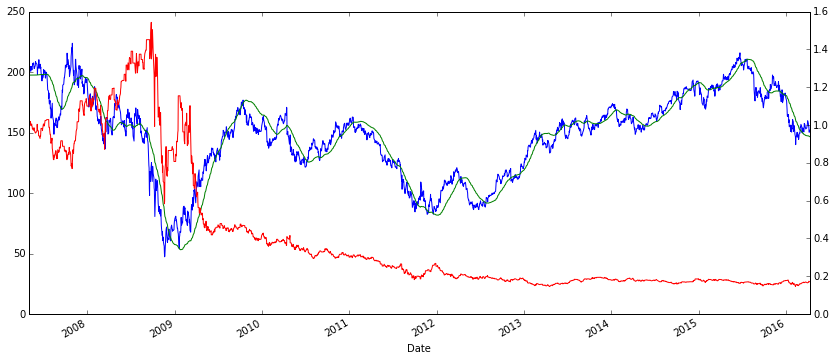

In [45]:
data = entire_system('GS', 35, 100000000)

data.prices.plot(figsize=(14,6))
data.kalman_price.plot()
data.eq_curve.plot(secondary_y=True)

years = (data.index[-1] - data.index[1]).days/365
total_ret = data.eq_curve[-10]**(1/years) - 1
print('annual return: %s' %total_ret)
var = np.std(data.returns)*np.sqrt(252)
print('variance: %s' %var)
print('sharpe: %s' %(total_ret/var))

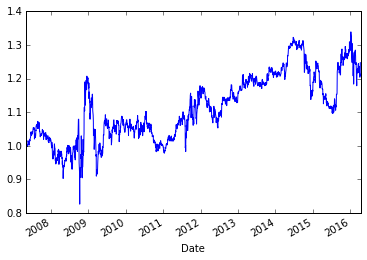

In [8]:
symbolsDF = pd.read_pickle('../data/symbolsDF.pkl')
bigDF = pd.DataFrame()
for symbol in symbolsDF.index[:10]:
    data = entire_system(symbol, 3.5, 160000)
    bigDF[symbol] = data.returns
np.cumprod(bigDF.mean(axis=1)+1).plot()

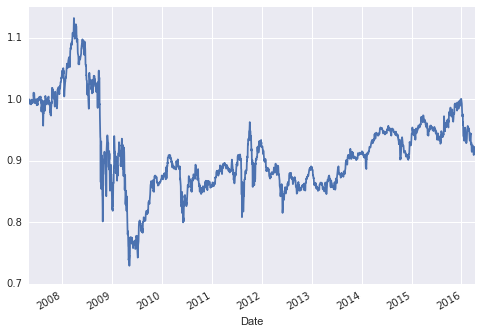

In [165]:
symbolsDF = pd.read_pickle('../data/symbolsDF.pkl')
bigDF = pd.DataFrame()
for symbol in symbolsDF.index[::20]:
    data = entire_system(symbol, 3.5, 1600000)
    bigDF[symbol] = data.returns
np.cumprod(bigDF.mean(axis=1)+1).plot()

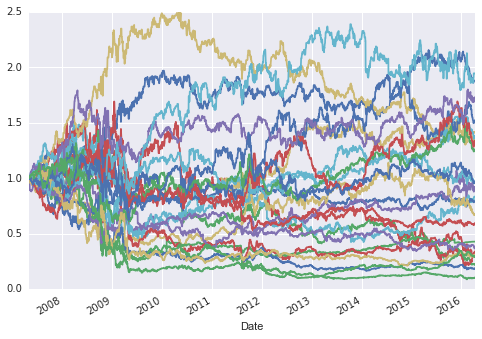

In [166]:
for col in bigDF.columns:
    np.cumprod(1+bigDF[col]).plot()